In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from sklearn import linear_model
pd.set_option('display.float_format', lambda x: '%f' % x)
figsize(14, 10)

In [3]:
video_data = pd.read_csv('data.csv', header=None)

In [4]:
video_data[[24,72,168]].describe()

,24,72,168
count,916.000000,916.000000,916.000000
mean,376765.517467,613303.341703,743209.837336
std,923646.739985,1653969.423316,2007963.831213
min,21173.000000,26162.000000,27139.000000
25%,124865.500000,148326.250000,153346.250000
50%,194357.500000,237417.500000,252287.000000
75%,326667.000000,433612.250000,522259.250000
max,15284639.000000,22916701.000000,27898237.000000


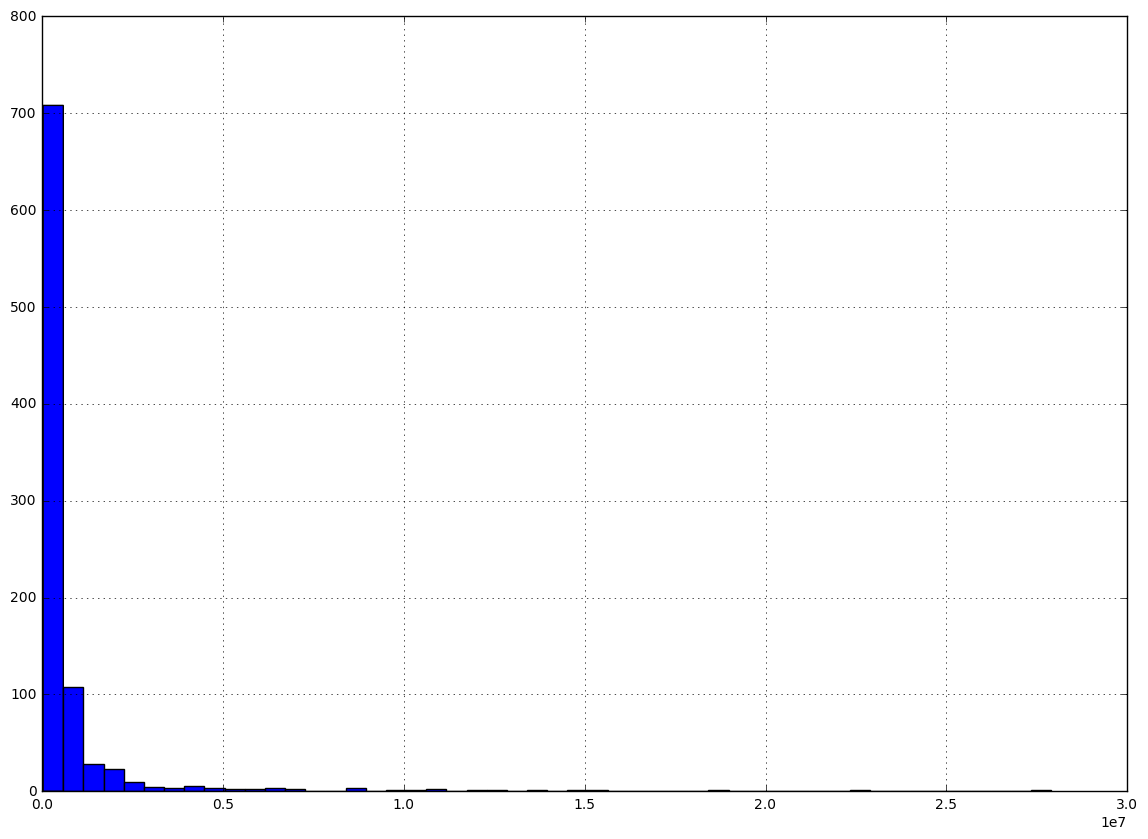

In [5]:
video_data[168].hist(bins=50)

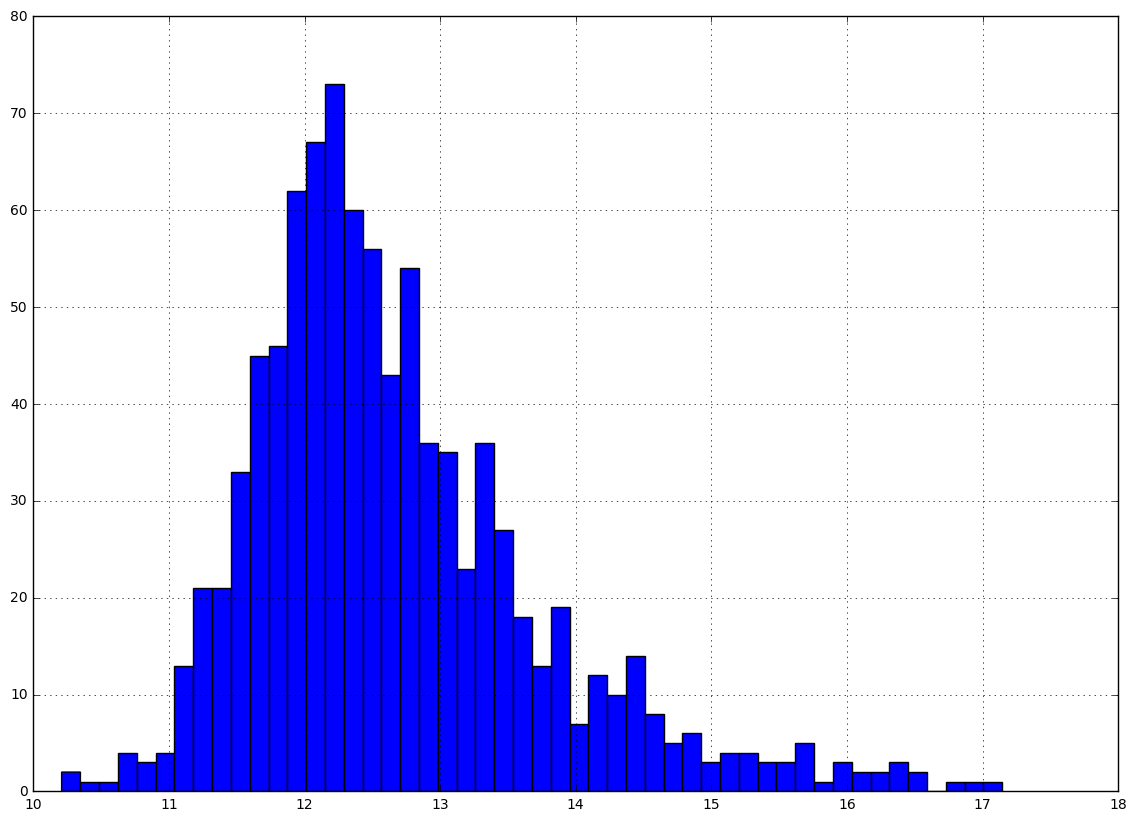

In [6]:
log_video_data = video_data.ix[:,1:].apply(np.log).replace([np.inf, -np.inf], np.nan).fillna(value=0)
log_video_data[168].hist(bins=50)

Looks like normal distribution.

We have similar results to popular paper [1].

In [7]:
last_col_log = log_video_data[168]
clean_mask = np.abs(last_col_log - last_col_log.mean()) <= (3*last_col_log.std())
log_clean_video_data = log_video_data[clean_mask]
clean_video_data = video_data[clean_mask]

In [8]:
log_clean_video_data.shape

(901, 168)

In [9]:
for i in xrange(1,24):
    print "{} {}".format(i, log_clean_video_data[[i,168]].corr()[i][168])

1 0.254538730486
2 0.784766630396
3 0.839769523076
4 0.855707427895
5 0.868397341276
6 0.880234403992
7 0.890877701641
8 0.901029007383
9 0.909913768305
10 0.916680712225
11 0.921825220471
12 0.926514244081
13 0.930555371925
14 0.934296896475
15 0.937993656305
16 0.94141611917
17 0.944743361696
18 0.947513658311
19 0.94990973856
20 0.952153689571
21 0.954276507379
22 0.956258130214
23 0.958027405797


In [10]:
def division_mask(dataset_len, fst_part):
    random_indicies = np.random.choice(dataset_len, size=int(fst_part*dataset_len), replace=False)
    msk = np.zeros(dataset_len, dtype=np.bool)
    msk[random_indicies] = True
    return msk

In [11]:
msk = division_mask(len(log_clean_video_data), 0.9)

lvideo_train = log_clean_video_data[msk].as_matrix().T[..., np.newaxis]
lvideo_test  = log_clean_video_data[~msk].as_matrix().T[..., np.newaxis]

video_train = clean_video_data[msk].ix[:,1:].as_matrix().T[..., np.newaxis]
video_test  = clean_video_data[~msk].ix[:,1:].as_matrix().T[..., np.newaxis]

In [12]:
video_train.shape, video_test.shape

((168, 810, 1), (168, 91, 1))

In [13]:
def mean_relative_squared_error(pred, groundtruth):
    return (((pred.flatten()/groundtruth.flatten()) - 1.0)**2).sum()/pred.shape[0]

def exp_mean_relative_squared_error(pred, groundtruth):
    return (((np.exp(pred.flatten() - groundtruth.flatten())) - 1.0)**2).sum()/pred.shape[0]

In [14]:
def lin_reg(train, test, error_func=mean_relative_squared_error):
    lin_reg = []
    lin_res = []
    for i in xrange(24):
        linear_regression = linear_model.LinearRegression()
        lin_reg += [linear_regression.fit(train[i], train[-1])]
    for i in xrange(24):
        lin_res += [ error_func(
                        lin_reg[i].predict(test[i])
                      , test[-1]) ]
    return lin_reg, lin_res

In [15]:
def multi_lin_reg(train, test, error_func=mean_relative_squared_error):
    multi_lin_reg = []
    multi_lin_res = []
    for i in xrange(24):
        linear_regression = linear_model.LinearRegression()
        multi_lin_reg += [linear_regression.fit(train[:(i+1)].T.squeeze(axis=0), train[-1])]
    for i in xrange(24):
        multi_lin_res += [ error_func(
                              multi_lin_reg[i].predict(test[:(i+1)].T.squeeze(axis=0))
                            , test[-1]) ]
    return multi_lin_reg, multi_lin_res

In [16]:
_, lin_res = lin_reg(video_train, video_test)
_, multi_lin_res = multi_lin_reg(video_train, video_test)

In [17]:
from collections import OrderedDict # We want constant color for every type
_comparisons = OrderedDict()
def show_comparisons(ignore=[]):
    plt.title('Comparison of basic methods')
    plt.xlabel('hour')
    plt.ylabel('mRSE')
    for label,data in _comparisons.iteritems():
        if label in ignore:
            continue
        plt.plot(np.arange(1, 25), data, marker='+', label=label)
    plt.legend()
    plt.show()

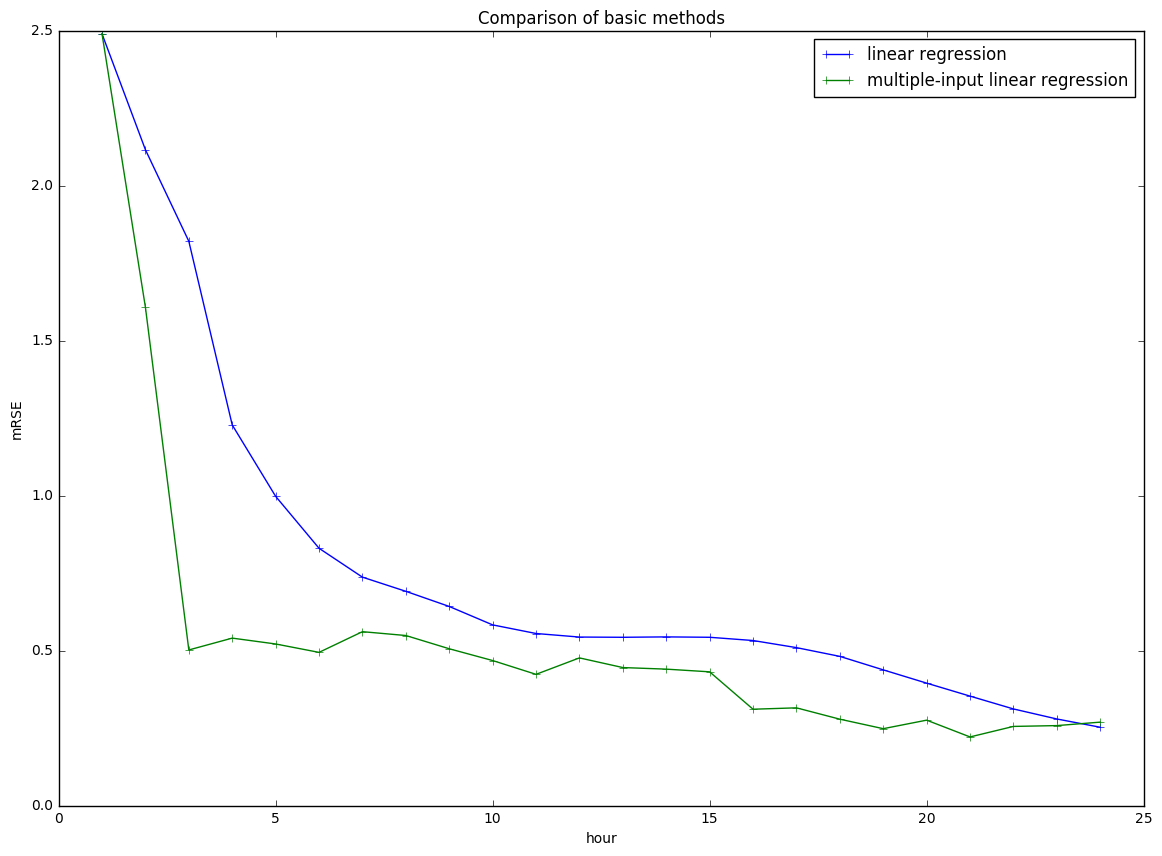

In [18]:
_comparisons['linear regression'] = lin_res
_comparisons['multiple-input linear regression'] = multi_lin_res
show_comparisons()

## Model 1: SVR

In [19]:
import sklearn.svm

In [20]:
def svr_reg(train, test, variance=None, error_func=mean_relative_squared_error):
    svr_reg = []
    
    data_transl = 0.0
    data_mult = 1.0
    if variance is not None:
        tmax = train.max()
        data_transl = -train.mean()
        data_mult = variance / tmax
        train = (train + data_transl)*data_mult
        test = (test + data_transl)*data_mult
        
    for i in xrange(24):
        svregression = sklearn.svm.SVR(C=10, gamma=0.1)
        svr_reg += [svregression.fit(train[:(i+1)].T.squeeze(axis=0), train[-1].ravel())]
    svr_res = []
    target_clean = (test[-1] / data_mult) - data_transl
    for i in xrange(24):
        svr_res += [ error_func(
                        (svr_reg[i].predict(test[:(i+1)].T.squeeze(axis=0)) / data_mult) - data_transl
                      , target_clean) ]
    return svr_reg, svr_res

In [21]:
float_video_train = video_train.astype(np.float64)
float_video_test = video_test.astype(np.float64)
svr_model, svr_res = svr_reg(float_video_train, float_video_test)

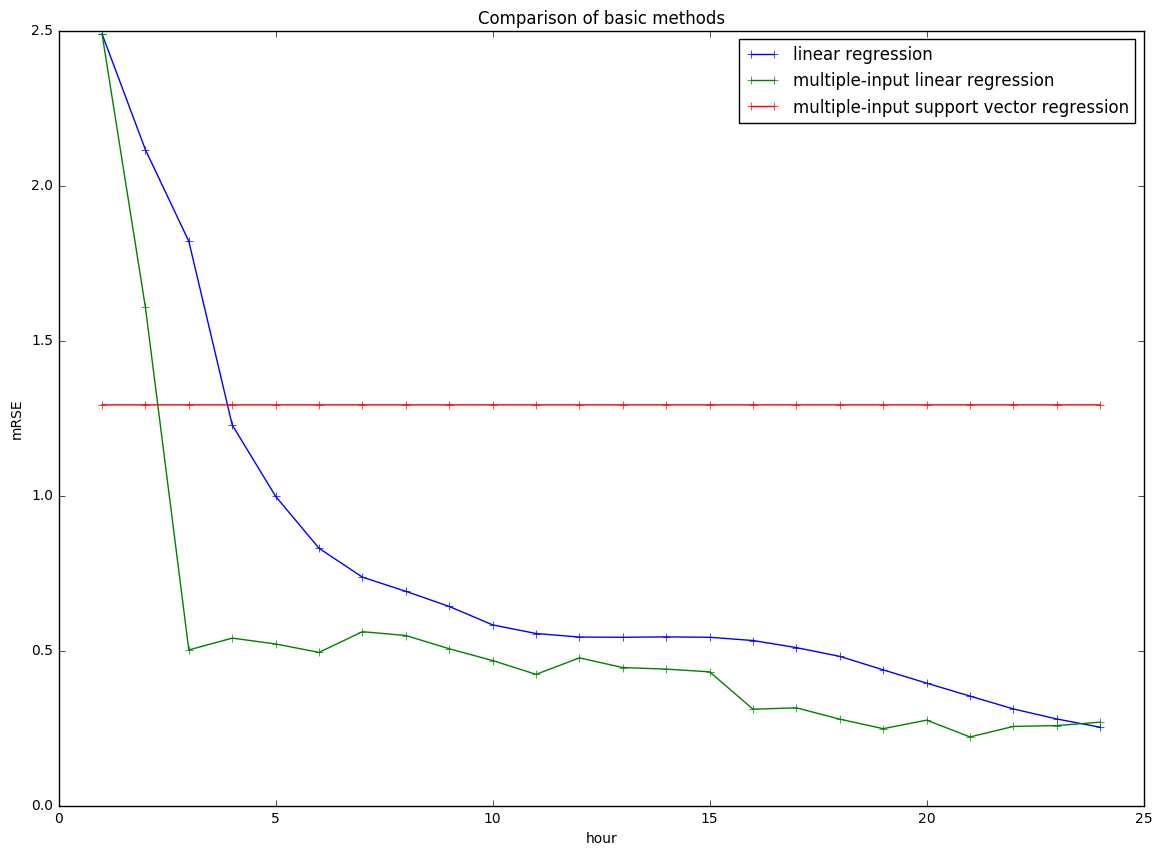

In [22]:
_comparisons['multiple-input support vector regression'] = svr_res
show_comparisons()

In [23]:
svr_model[0].predict(video_test[:1].T.squeeze(axis=0))

Shape: (91,)
[ 244748.499773    244761.79657254  244768.499773    244748.499773
  244767.67892301  244768.48315743  244775.20297346  244768.499773
  244768.15206995  244768.499773    244768.499773    244768.499773
  244756.48384321  244768.49977297  244767.67892301  244768.499773
  244768.499773    244768.499773    244767.67892301  244768.499773
  244768.499773    244768.499773    244768.499773    244768.48315743
  244759.45139882  244761.79611854  244768.499773    244768.499773
  244768.499773    244768.500227    244768.499773    244768.499773
  244768.499773    244768.499773    244768.50280839  244768.42530717
  244768.499773    244772.5654696   244768.499773    244768.499773
  244768.499773    244768.499773    244768.499773    244768.499773
  244766.48080782  244768.499773    244770.51873772  244773.48245616
  244768.499773    244758.499773    244768.499773    244768.499773
  244768.499773    244748.499773    244768.499773    244768.499773
  244768.48315743  244768.499773    244768.

Oops... SVR produced almost the same results for every example. We should normalize the data. Standard is zero mean unit variance but the difference between big numbers of views can be "lost" if we pack everything to [-1,1], lets check candidates.

In [24]:
def divide_dataset(dataset, fst_part, axis=0):
    msk = division_mask(dataset.shape[axis], fst_part)
    positive_indexer = tuple([slice(None) if ax != axis else msk for ax in xrange(dataset.ndim)])
    negative_indexer = tuple([slice(None) if ax != axis else ~msk for ax in xrange(dataset.ndim)])
    return dataset[positive_indexer], dataset[negative_indexer]

In [25]:
best = 1
best_val = 1000000.0
exp_train, exp_test = divide_dataset(float_video_train, 0.9, axis=1)
# We are tweaking hyperparameter, so it's not a good idea to use test set
for variance in xrange(1, 50, 2):
    _, svr_res = svr_reg(exp_train, exp_test, variance)
    mmrse = np.array(svr_res).mean()
    if mmrse < best_val:
        best_val = mmrse
        best = variance
    print "Variance {}: {} length-mean mRSE".format(variance, mmrse)
print "Best: {}".format(best)
svr_best_var = best

Variance 1: 15.2971480194 length-mean mRSE
Variance 3: 0.886580666255 length-mean mRSE
Variance 5: 0.515847097507 length-mean mRSE
Variance 7: 0.347249575619 length-mean mRSE
Variance 9: 0.269770149025 length-mean mRSE
Variance 11: 0.221118646736 length-mean mRSE
Variance 13: 0.19139123944 length-mean mRSE
Variance 15: 0.168485351235 length-mean mRSE
Variance 17: 0.153344025315 length-mean mRSE
Variance 19: 0.141011740151 length-mean mRSE
Variance 21: 0.133115466239 length-mean mRSE
Variance 23: 0.127538343631 length-mean mRSE
Variance 25: 0.124022086554 length-mean mRSE
Variance 27: 0.121851875418 length-mean mRSE
Variance 29: 0.119849573183 length-mean mRSE
Variance 31: 0.119154282478 length-mean mRSE
Variance 33: 0.118295225345 length-mean mRSE
Variance 35: 0.11788163144 length-mean mRSE
Variance 37: 0.118118581043 length-mean mRSE
Variance 39: 0.118662262468 length-mean mRSE
Variance 41: 0.119889918392 length-mean mRSE
Variance 43: 0.12150566885 length-mean mRSE
Variance 45: 0.1234

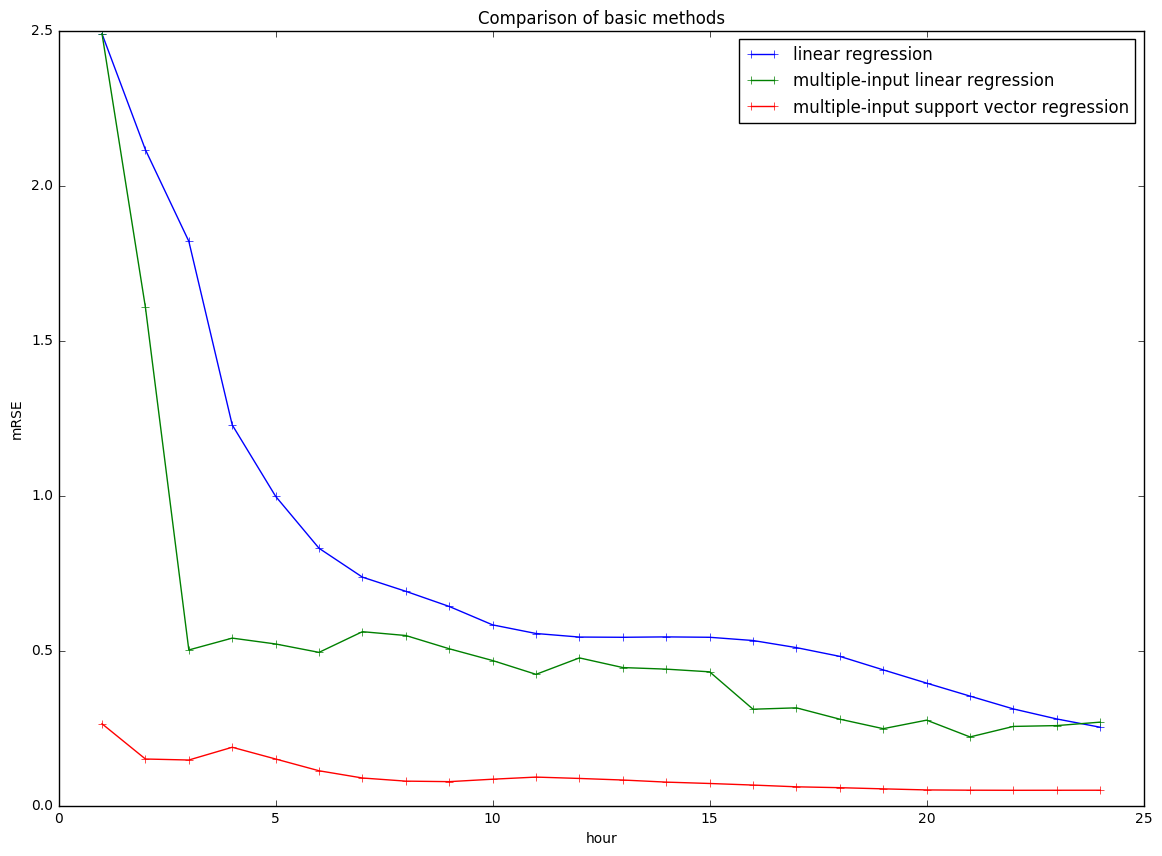

In [26]:
_, svr_res = svr_reg(float_video_train, float_video_test, svr_best_var)
_comparisons['multiple-input support vector regression'] = svr_res
show_comparisons()

Some of the models in [2] use growth instead of total count for each hour. Let's check that.

In [27]:
def get_diff_dataset(dataset):
    return np.concatenate((np.diff(dataset, axis=0)[:-1], dataset[:1], dataset[-1:]), axis=0) # first and last the same - rest diff

In [28]:
dvideo_train = get_diff_dataset(video_train).astype(np.float64)
dvideo_test = get_diff_dataset(video_test).astype(np.float64)

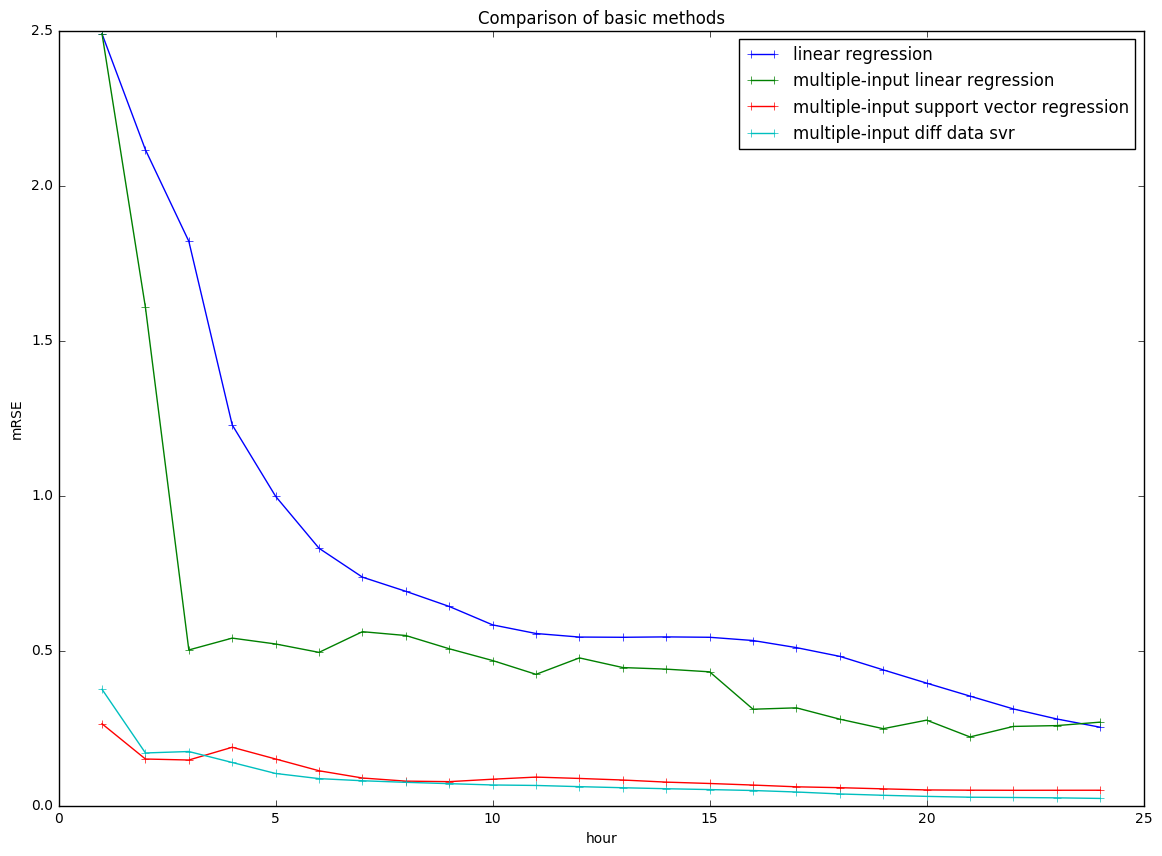

In [29]:
_, dsvr_res = svr_reg(dvideo_train, dvideo_test, svr_best_var)
_comparisons['multiple-input diff data svr'] = dsvr_res
show_comparisons()

![nn](https://pbs.twimg.com/media/CKnUC7MWUAA8s40.png:large)

In [30]:
import lasagne
import theano
import theano.tensor as T

In [31]:
# Based on Lasagne MNIST example
def build_mlp(feat_num, hidden_nums=[800,800]):
    input_var = T.matrix('inputs')
    target_var = T.vector('targets')
    l_in = lasagne.layers.InputLayer(shape=(None, feat_num),
                                     input_var=input_var)

    # Apply 20% dropout to the input data:
    l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)
    
    hid = l_in_drop
    for hnum in hidden_nums:
        hid = lasagne.layers.DenseLayer(hid, num_units=hnum, nonlinearity=lasagne.nonlinearities.rectify)
        hid = lasagne.layers.DropoutLayer(hid, p=0.5)

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    network = lasagne.layers.DenseLayer(
            hid, num_units=1,
            nonlinearity=lasagne.nonlinearities.identity)

    # Each layer is linked to its incoming layer(s), so we only need to pass
    # the output layer to give access to a network in Lasagne:
    prediction = lasagne.layers.get_output(network)
    loss = ((prediction.flatten()/target_var - 1.0)**2).sum()/prediction.shape[0]
    params = lasagne.layers.get_all_params(network, trainable=True)
             
    updates = lasagne.updates.nesterov_momentum(
                loss, params, learning_rate=0.01, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    val_loss = ((test_prediction.flatten()/target_var - 1.0)**2).sum()/test_prediction.shape[0]

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [val_loss])
    test_fn = theano.function([input_var], [test_prediction])
    
    return network, train_fn, val_fn, test_fn


In [32]:
def get_params(network):
    return {p: p.get_value() for p in lasagne.layers.get_all_params(network)}

def set_params(network, params):
    for p in lasagne.layers.get_all_params(network):
        p.set_value(params[p])

In [33]:
def nn_train(num_feat, train_dataset, hidden_nums=None):
    mlp_kwargs = {}
    if hidden_nums != None:
        mlp_kwargs = {'hidden_nums': hidden_nums}
    
    network, train, valid, test = build_mlp(num_feat, **mlp_kwargs)
    i = 0
    exp_train, exp_valid = divide_dataset(train_dataset.astype(np.float32), 0.9, axis=1)
    best_valid_epoch = 0
    best_valid_error = 10000000.0
    best_valid_params = None
    while True:
        i += 1
        train(exp_train[:num_feat].squeeze(axis=2).T, exp_train[-1].flatten())
        valid_error = valid(exp_valid[:num_feat].squeeze(axis=2).T, exp_valid[-1].flatten())[0]
        if valid_error < best_valid_error:
            best_valid_error = valid_error
            best_valid_params = get_params(network)
            best_valid_epoch = i
        if i - best_valid_epoch > 10:
            break
    set_params(network, best_valid_params)
    return test

In [34]:
def nn_reg(train, test, error_func=mean_relative_squared_error, **kwargs):
    nn_reg = []

    for i in xrange(24):
        print i+1
        nn_reg += [nn_train(i+1, train, **kwargs)]
    
    nn_res = []
    for i in xrange(24):
        norm_output = np.array(nn_reg[i](test[:(i+1)].T.squeeze(axis=0).astype(np.float32))).flatten()
        nn_res += [ mean_relative_squared_error(
                        norm_output
                      , test[-1].flatten()) ]
        
    return nn_reg, nn_res

In [35]:
_, nn_res = nn_reg(float_video_train, float_video_test, hidden_nums=[400,200])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


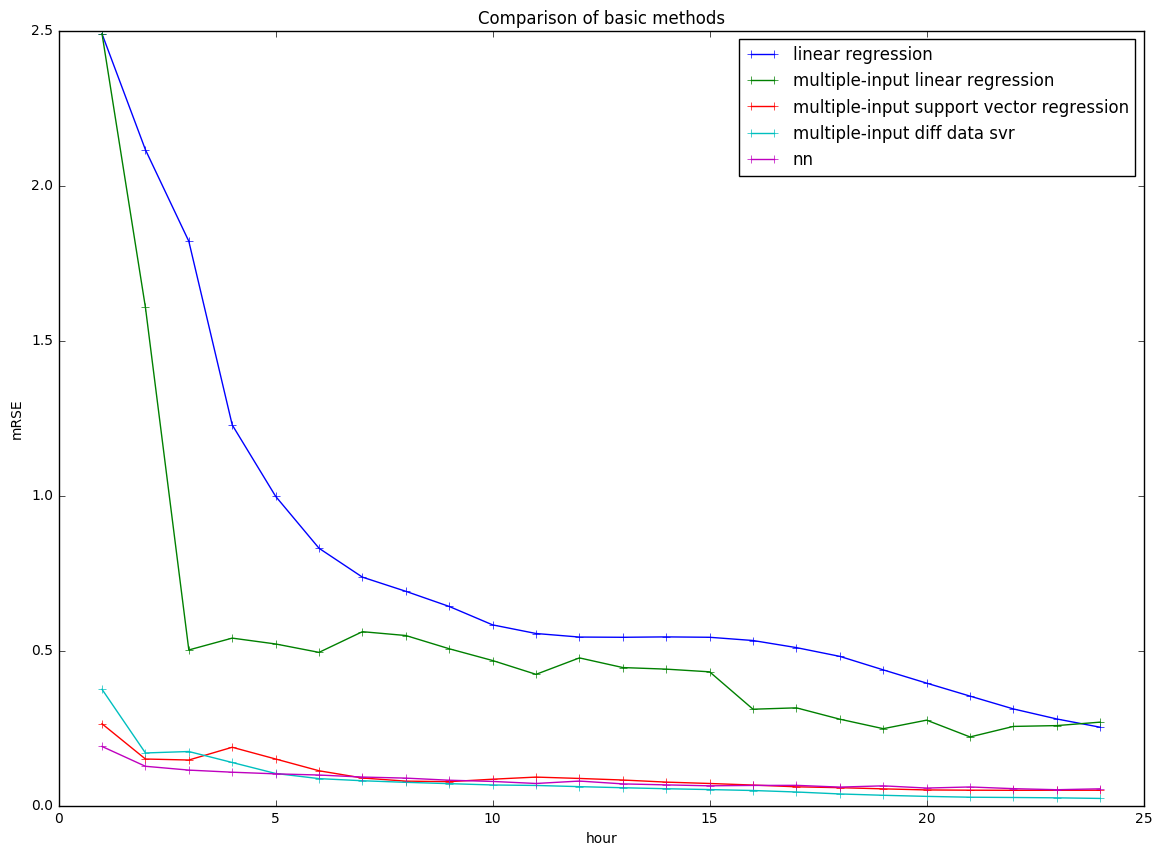

In [36]:
_comparisons['nn'] = nn_res
show_comparisons()

## What can be done.
The biggest drawback of this notebook is lack of hyperparameter tuning, but nevertheless one can see that non-linear methods works better, especially on first-hours of uploaded video.

# Bibliography

[1] Gabor Szabo and Bernardo A. Huberman, Predicting the popularity of online content

[2] Tomasz Trzcinski and Przemyslaw Rokita, Predicting popularity of online videos using Support Vector Regression